In [11]:
import numpy as np

In [72]:
class ConvLayer():
    def __init__(self,num_filters,input_channel,kernel_size,padding = 0,stride = 1):
        self.num_filters = num_filters
        self.input_channel = input_channel
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.weights = np.random.randn(num_filters,input_channel,kernel_size,kernel_size)
        self.bias = np.zeros(num_filters)
    def forward(self,input):
        self.input = input
        batch_size, input_c, input_h,input_w = input.shape
        input_padded = input
        if(self.padding > 0) :
            input_padded = np.pad(input, 
                                  ((0,0), (0,0), (self.padding, self.padding), (self.padding, self.padding)), 
                                  mode='constant', constant_values=0)
        pad_h, pad_w = input_padded.shape[2],input_padded.shape[3]
        out_h = int((pad_h - self.kernel_size) / self.stride) + 1
        out_w = int((pad_w - self.kernel_size) / self.stride) + 1

        output = np.zeros((batch_size,self.num_filters,out_h,out_w))
        stride =self.stride
        size = self.kernel_size
        for b in range(batch_size):
            for k in range(self.num_filters):
                for i in range(out_h):
                    for j in range (out_w):
                        hStart = i*stride
                        hEnd = hStart + size
                        wStart = j * stride
                        wEnd = wStart + size
                        inputSlice = input_padded[b,:,hStart:hEnd,wStart:wEnd]
                        output[b,k,i,j] = np.sum(inputSlice * self.weights[k]) + self.bias[k]
        return output
    def fft_forward(self, input):
        batch_size, input_c, input_h, input_w = input.shape
        input_padded = input
        if self.padding > 0:
            input_padded = np.pad(input,
                                ((0, 0), (0, 0), 
                                (self.padding, self.padding), 
                                (self.padding, self.padding)),
                                mode='constant', constant_values=0)
        
        pad_h, pad_w = input_padded.shape[2], input_padded.shape[3]
        out_h = int((pad_h - self.kernel_size) / self.stride) + 1
        out_w = int((pad_w - self.kernel_size) / self.stride) + 1
        
        output = np.zeros((batch_size, self.num_filters, out_h, out_w))
        for b in range(batch_size):
            for k in range(self.num_filters):
                filter_output = np.zeros((pad_h, pad_w), dtype=np.complex128)
                for c in range(input_c):
                    input_channel = input_padded[b, c, :, :]  # ukuran: (pad_h, pad_w)
                    kernel_channel = self.weights[k, c, :, :]  # ukuran: (K, K)
                    kernel_padded = np.zeros((pad_h, pad_w), dtype=np.float32)
                    kernel_padded[:self.kernel_size, :self.kernel_size] = kernel_channel
                    
                   
                    input_fft = np.fft.fft2(input_channel)
                    kernel_fft = np.fft.fft2(kernel_padded)
                    
                   
                    result_fft = input_fft * kernel_fft
                    
                    
                    result_spatial = np.real(np.fft.ifft2(result_fft))
                    filter_output += result_spatial
                
                # Add bias

                filter_output = filter_output + self.bias[k]
                # Handle stride - sample output
                for i in range(out_h):
                    for j in range(out_w):
                        h_idx = i * self.stride
                        w_idx = j * self.stride
                        output[b, k, i, j] = filter_output[h_idx, w_idx]
        return output
    def backward(self, output_gradient, learning_rate):
        # output_gradient shape: (Batch, Num_Filters, Out_H, Out_W)
        batch_size, num_filters, out_h, out_w = output_gradient.shape
        
        # dL/dW 
        kernels_gradient = np.zeros(self.weights.shape) 
        # dL/dX 
        input_gradient = np.zeros(self.input.shape)
        
        stride = self.stride
        
        for b in range(batch_size):
            for k in range(num_filters):
                for i in range(out_h):
                    for j in range(out_w):
                        
                        # Lokasi di input yang berhubungan dengan output[i,j]
                        h_start = i * stride
                        h_end = h_start + self.kernel_size
                        w_start = j * stride                        
                        w_end = w_start + self.kernel_size
                        
                        # Ambil potongan Input dan Error (Gradient) di titik ini
                        input_slice = self.input[b, :, h_start:h_end, w_start:w_end]
                        grad_val = output_gradient[b, k, i, j]
                        
                        # HITUNG GRADIENT KERNEL (dL/dW) 
                        # Rumus: Input * Error
                        kernels_gradient[k] += input_slice * grad_val
                        
                        # HITUNG GRADIENT INPUT (dL/dX) 
                        # Rumus: Error * Weight
                        # Kirim error balik ke input pixel yang terlibat
                        input_gradient[b, :, h_start:h_end, w_start:w_end] += self.weights[k] * grad_val

    
        bias_gradient = np.sum(output_gradient, axis=(0, 2, 3))
        self.weights -= learning_rate * kernels_gradient
        self.bias -= learning_rate * bias_gradient
        
        return input_gradient


In [73]:
import cv2
img_path = "D:/MakalahAlgeo2/Tumor-Detection-Optimization-using-FFT/dataset/Training/glioma/Tr-gl_0010.jpg"
# Read the image file
# The result is a NumPy array (matrix)
img_as_matrix = cv2.imread(img_path)

# Display the resulting matrix shape
print(f"Image shape: {img_as_matrix.shape}")

Image shape: (512, 512, 3)


In [74]:
input_image = img_as_matrix
input_image = np.expand_dims(input_image,axis = 0)

In [75]:
input_image.shape

(1, 512, 512, 3)

In [76]:
input_ready = np.transpose(input_image, (0,3,1,2))

In [77]:
input_ready

array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]]], shape=(1, 3, 512, 512), dtype=uint8)

In [90]:
conv_valid = ConvLayer(num_filters=5, input_channel=3, kernel_size=3, padding=0)
out1 = conv_valid.forward(input_ready)

In [93]:
conv_valid

In [92]:
out_fft = conv_valid.fft_forward(input_ready)

C:\Users\LOQ\AppData\Local\Temp\ipykernel_43984\492736475.py:79: ComplexWarning: Casting complex values to real discards the imaginary part
  output[b, k, i, j] = filter_output[h_idx, w_idx]


In [94]:
out1

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 

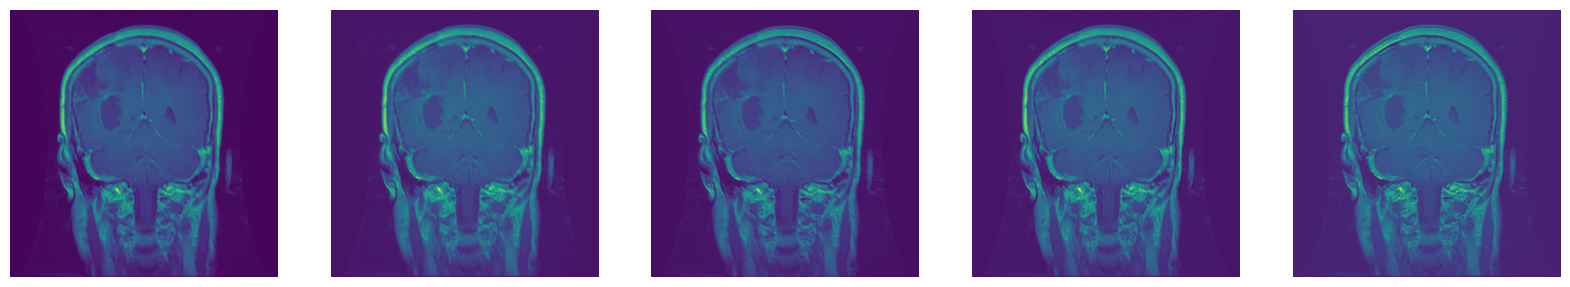

In [95]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
for fil in range(out1.shape[1]) :
    ax[fil].imshow(out1[0,fil,:,:])
    ax[fil].axis('off')

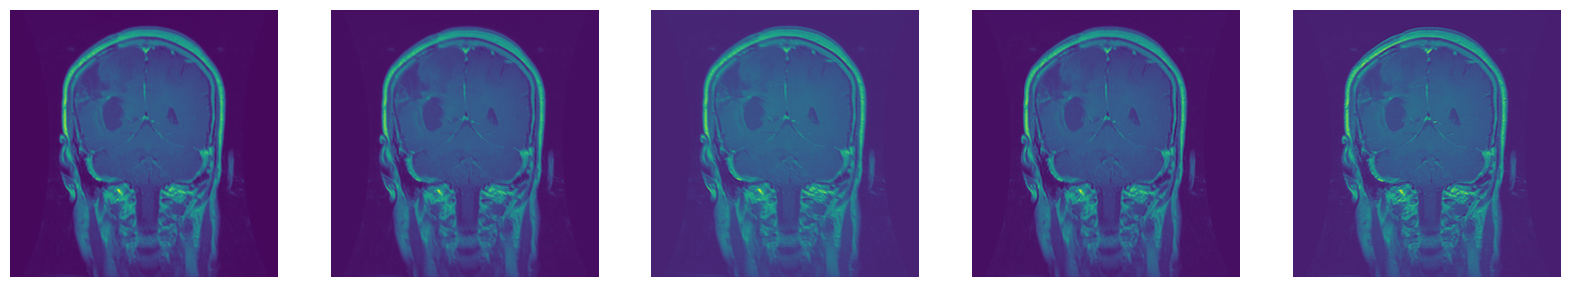

In [96]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
for fil in range(out_fft.shape[1]) :
    ax[fil].imshow(out_fft[0,fil,:,:])
    ax[fil].axis('off')

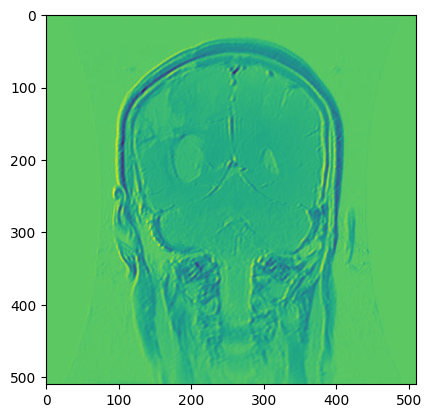

In [70]:
plt.imshow(out_fft[0][3][:][:])